In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset, Subset
import sklearn.metrics as sk

In [3]:
# Load the data from npz file
data = np.load(r"D:\Study\Research-Lee 2024\Unilever\Unilever Data\FABRIC ENHANCER_dataset_processed.npz")

# Extract the arrays
X = data['X']  # Shape: (timestep/index, prediction window/lookback, nodes, features)
Y = data['Y']  # Shape: (timestep/index, prediction window/lookback, nodes, features)

# Drop all features except the first one for both X and Y
X = X[:, :, :, :1]  # Keep only the first feature
Y = Y[:, :, :, :1]  # Keep only the first feature

# Reshape Y to match the output format, if necessary
# Y is expected to have shape (timestep/index, prediction window, nodes, 1)
# If Y's shape is already correct, skip this step
X = X.squeeze(-1)
Y = Y.squeeze(-1)  # Remove the last dimension

# Split the data into train, validation, and test sets (70%, 15%, 15%)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = Y[:train_size], Y[train_size:train_size + val_size], Y[train_size + val_size:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: torch.Size([121, 6, 2171])
y_train shape: torch.Size([121, 6, 2171])
X_val shape: torch.Size([26, 6, 2171])
y_val shape: torch.Size([26, 6, 2171])
X_test shape: torch.Size([27, 6, 2171])
y_test shape: torch.Size([27, 6, 2171])


In [32]:
# Define the LSTM model
class AirModel(nn.Module):
    def __init__(self, input_sz, hidden_sz, output_sz, n_steps, dropout_prob=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_sz, hidden_size=hidden_sz, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.linear = nn.Linear(hidden_sz, output_sz * n_steps)
        self.output_sz = output_sz
        self.n_steps = n_steps

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])  # Use the output of the last time step
        x = self.linear(x)
        x = torch.relu(x)
        x = x.view(-1, self.n_steps, self.output_sz)  # Ensure correct output shape
        return x

# Model parameters
input_size = X_train.shape[2]
output_size = y_train.shape[2] 
model = AirModel(input_size, hidden_sz=50, output_sz=output_size, n_steps=6, dropout_prob=0)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()
# Assuming X_train, y_train, X_test, y_test are already defined as tensors
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=16, shuffle=False)

print("output size:", output_size)
print("Train samples", train_size)

train_rmse_list = []
train_mae_list = []
train_r2_list = []
test_rmse_list = []
test_mae_list = []
test_r2_list = []

# Training loop
n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 2 == 0:
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train)
            train_loss = loss_fn(y_pred_train, y_train)
            train_rmse = torch.sqrt(train_loss)
            train_mae = torch.mean(torch.abs(y_pred_train - y_train))
            train_r2 = sk.r2_score(y_train.numpy().flatten(), y_pred_train.numpy().flatten())
            train_rmse_list.append(train_rmse.item())
            train_mae_list.append(train_mae.item())
            train_r2_list.append(train_r2)

            y_pred_test = model(X_test)
            test_loss = loss_fn(y_pred_test, y_test)
            test_rmse = torch.sqrt(test_loss)
            test_mae = torch.mean(torch.abs(y_pred_test - y_test))
            test_r2 = sk.r2_score(y_test.numpy().flatten(), y_pred_test.numpy().flatten())
            test_rmse_list.append(test_rmse.item())
            test_mae_list.append(test_mae.item())
            test_r2_list.append(test_r2)

            print(f"Epoch {epoch}: Train RMSE {train_rmse:.4f}, MAE {train_mae:.4f}, R^2 {train_r2:.4f} | Test RMSE {test_rmse:.4f}, MAE {test_mae:.4f}, R^2 {test_r2:.4f}")


output size: 2171
Train samples 121
Epoch 0: Train RMSE 692.6045, MAE 97.6894, R^2 -0.0134 | Test RMSE 604.3315, MAE 65.8756, R^2 -0.0106
Epoch 2: Train RMSE 688.2067, MAE 98.2433, R^2 -0.0006 | Test RMSE 604.3540, MAE 69.5226, R^2 -0.0107
Epoch 4: Train RMSE 684.2033, MAE 98.5569, R^2 0.0110 | Test RMSE 604.5872, MAE 72.5787, R^2 -0.0115
Epoch 6: Train RMSE 680.5494, MAE 98.7587, R^2 0.0215 | Test RMSE 604.9619, MAE 75.0398, R^2 -0.0127
Epoch 8: Train RMSE 677.1440, MAE 98.8255, R^2 0.0313 | Test RMSE 604.8545, MAE 70.9490, R^2 -0.0124
Epoch 10: Train RMSE 676.5033, MAE 98.7802, R^2 0.0331 | Test RMSE 602.4489, MAE 64.8195, R^2 -0.0043
Epoch 12: Train RMSE 669.1633, MAE 99.8281, R^2 0.0540 | Test RMSE 599.7836, MAE 66.5695, R^2 0.0045
Epoch 14: Train RMSE 665.0280, MAE 100.1995, R^2 0.0657 | Test RMSE 598.8202, MAE 70.7746, R^2 0.0077
Epoch 16: Train RMSE 661.4290, MAE 100.3556, R^2 0.0758 | Test RMSE 597.7000, MAE 71.5647, R^2 0.0114
Epoch 18: Train RMSE 658.0278, MAE 100.1913, R^2 0

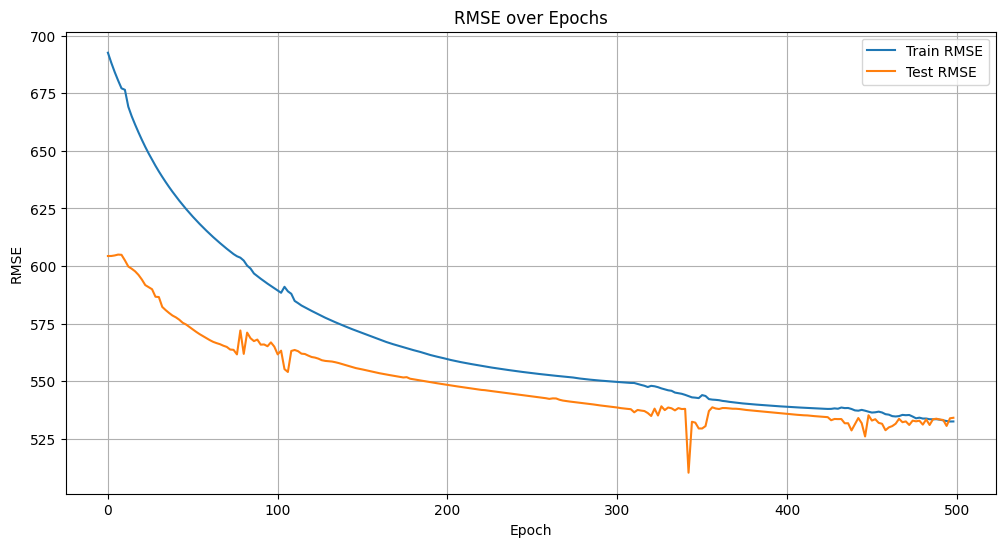

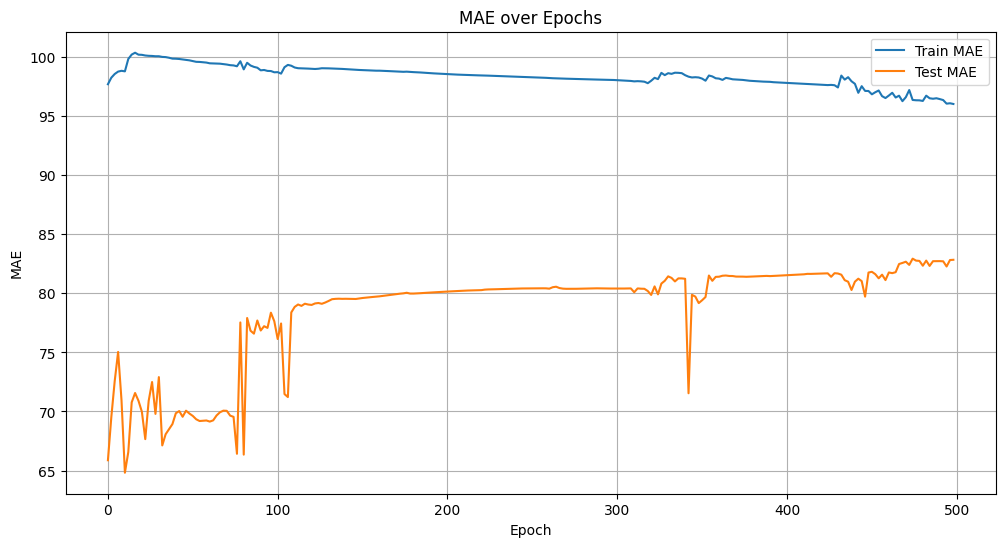

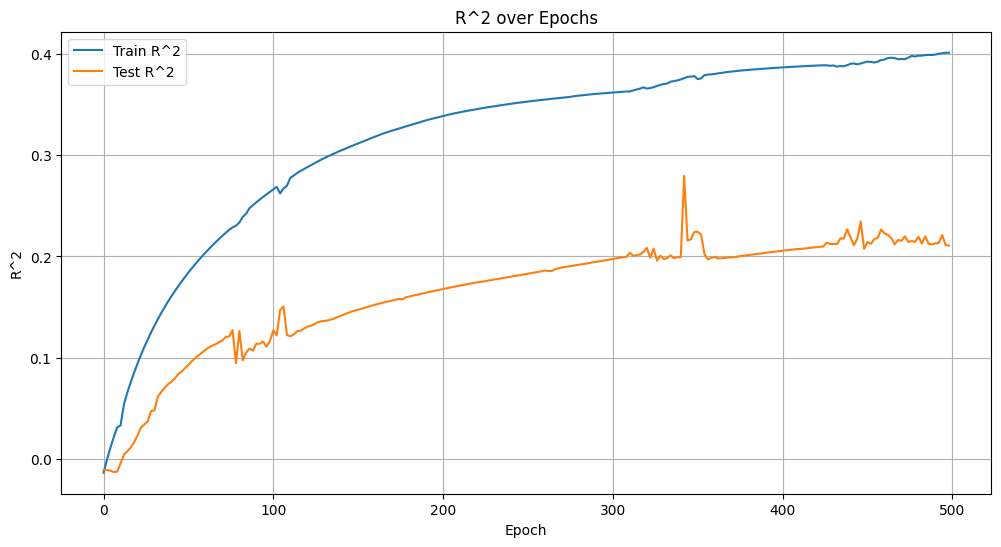

In [33]:
# Plot RMSE over epochs
plt.figure(figsize=(12, 6))
plt.plot(range(0, n_epochs, 2), train_rmse_list, label='Train RMSE')
plt.plot(range(0, n_epochs, 2), test_rmse_list, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot MAE over epochs
plt.figure(figsize=(12, 6))
plt.plot(range(0, n_epochs, 2), train_mae_list, label='Train MAE')
plt.plot(range(0, n_epochs, 2), test_mae_list, label='Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot R^2 over epochs
plt.figure(figsize=(12, 6))
plt.plot(range(0, n_epochs, 2), train_r2_list, label='Train R^2')
plt.plot(range(0, n_epochs, 2), test_r2_list, label='Test R^2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.title('R^2 over Epochs')
plt.legend()
plt.grid(True)
plt.show()


torch.Size([121, 6])
(121, 6, 2171)


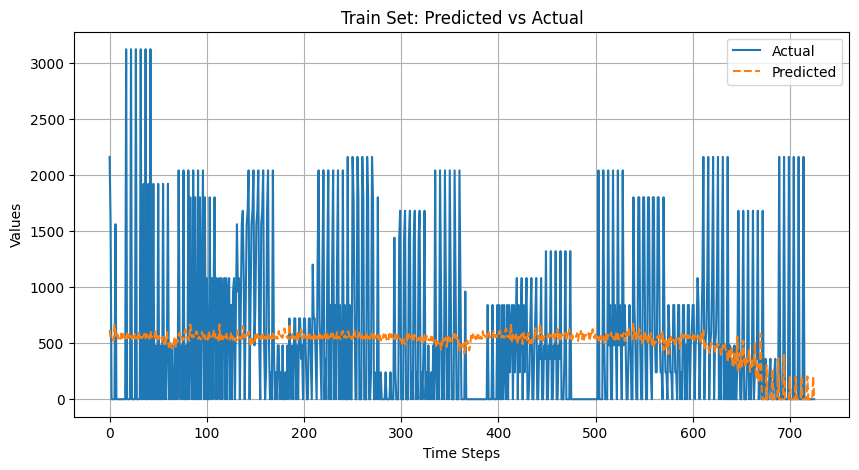

torch.Size([26, 6])
(26, 6, 2171)


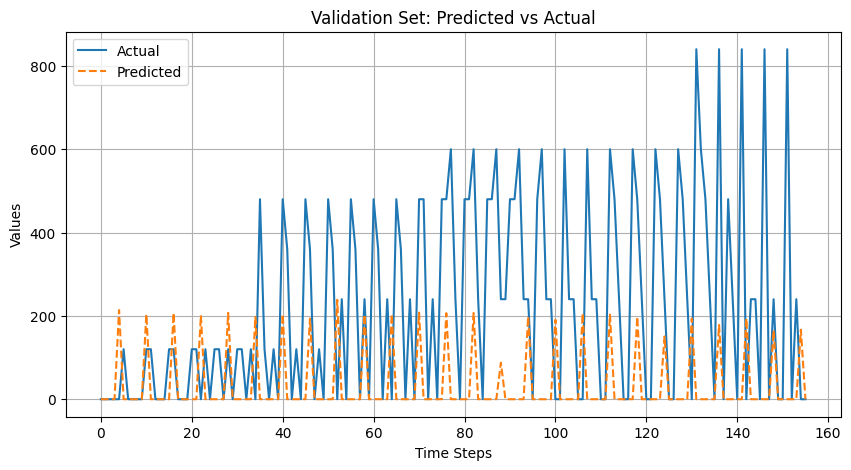

torch.Size([27, 6])
(27, 6, 2171)


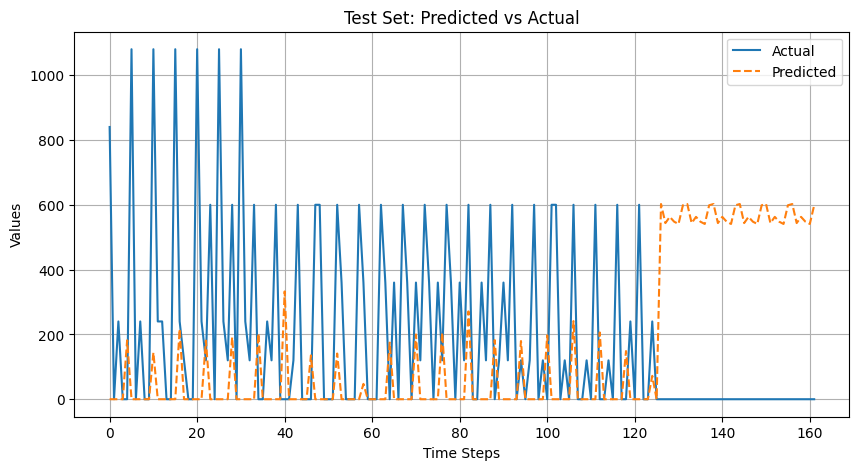

In [34]:
# Function to plot predicted vs actual
def plot_pred_vs_actual(y_true, y_pred, title):
    for i in range(1):
        plt.figure(figsize=(10, 5))
        plt.plot(y_true[:,:,i].flatten(), label='Actual')
        plt.plot(y_pred[:,:,i].flatten(), label='Predicted', linestyle='dashed')
        plt.title(title)
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.legend()
        plt.grid(True)
        plt.show()

# Evaluate and plot predicted vs actual
def evaluate_and_plot(model, X, y, title):
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        print(y_pred[:,:,0].shape)
        
        y_pred = y_pred.cpu().numpy()
        y_true = y.cpu().numpy()
        
        print(y_true.shape)

        plot_pred_vs_actual(y_true, y_pred, title)

# Call the function for train, validation, and test sets
evaluate_and_plot(model, X_train, y_train, 'Train Set: Predicted vs Actual')
evaluate_and_plot(model, X_val, y_val, 'Validation Set: Predicted vs Actual')
evaluate_and_plot(model, X_test, y_test, 'Test Set: Predicted vs Actual')